# EXAMEN MN

In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Procesamiento de datos

In [6]:
def procesar_datos_sinca(ruta_archivo, nombre_ciudad):
    # 1. Cargar el archivo especificando separador ';' y decimal ','
    # El parámetro 'dtype' asegura que la fecha y hora se lean como texto inicialmente para no perder ceros
    df = pd.read_csv(ruta_archivo, sep=';', decimal=',', dtype={'FECHA (YYMMDD)': str, 'HORA (HHMM)': str})
    
    # 2. Renombrar columnas para facilitar el trabajo
    df.rename(columns={
        'FECHA (YYMMDD)': 'fecha_raw',
        'HORA (HHMM)': 'hora_raw',
        'Registros validados': 'mp25'
    }, inplace=True)
    
    # 3. Convertir fecha extraña '991231' a datetime real
    df['fecha'] = pd.to_datetime(df['fecha_raw'], format='%y%m%d')
    
    # 4. Filtrar solo Invierno (Mayo, Junio, Julio, Agosto)
    # Meses: 5, 6, 7, 8
    df = df[df['fecha'].dt.month.isin([5, 6, 7, 8])].copy()
    
    # 5. Limpieza de la columna de valor (MP2.5)
    # A veces vienen datos vacíos o preliminares. Priorizamos 'Registros validados'.
    df['mp25'] = pd.to_numeric(df['mp25'], errors='coerce')
    
    # Eliminar filas donde no haya medición (NaN)
    df.dropna(subset=['mp25'], inplace=True)
    
    # 6. Crear etiqueta de clasificación de calidad del aire
    def clasificar_aire(valor):
        if valor <= 49: return "Bueno"
        elif valor <= 79: return "Regular"
        elif valor <= 109: return "Alerta"
        elif valor <= 169: return "Pre-emergencia"
        else: return "Emergencia"
        
    df['estado'] = df['mp25'].apply(clasificar_aire)
    
    # Agregar etiqueta de ciudad
    df['ciudad'] = nombre_ciudad
    
    # Seleccionar columnas finales limpias
    df_final = df[['fecha', 'hora_raw', 'mp25', 'estado', 'ciudad']].sort_values('fecha')
    
    print(f"Procesado {nombre_ciudad}: {len(df_final)} registros de invierno encontrados.")
    return df_final

# Procesar datos para Santiago y Temuco
df_santiago = procesar_datos_sinca('datosSantiago.csv', 'Santiago')
df_temuco = procesar_datos_sinca('datosTemuco.csv', 'Temuco')

# Vista previa
display(df_santiago.head())
display(df_temuco.head())

Procesado Santiago: 73924 registros de invierno encontrados.
Procesado Temuco: 37774 registros de invierno encontrados.


,fecha,hora_raw,mp25,estado,ciudad
2903,2000-05-01,0000,9.0,Bueno,Santiago
2926,2000-05-01,2300,21.0,Bueno,Santiago
2925,2000-05-01,2200,22.0,Bueno,Santiago
2924,2000-05-01,2100,17.0,Bueno,Santiago
2923,2000-05-01,2000,15.0,Bueno,Santiago


,fecha,hora_raw,mp25,estado,ciudad
116879,2013-05-01,0000,10.0,Bueno,Temuco
116902,2013-05-01,2300,28.0,Bueno,Temuco
116901,2013-05-01,2200,59.0,Regular,Temuco
116900,2013-05-01,2100,39.0,Bueno,Temuco
116899,2013-05-01,2000,44.0,Bueno,Temuco


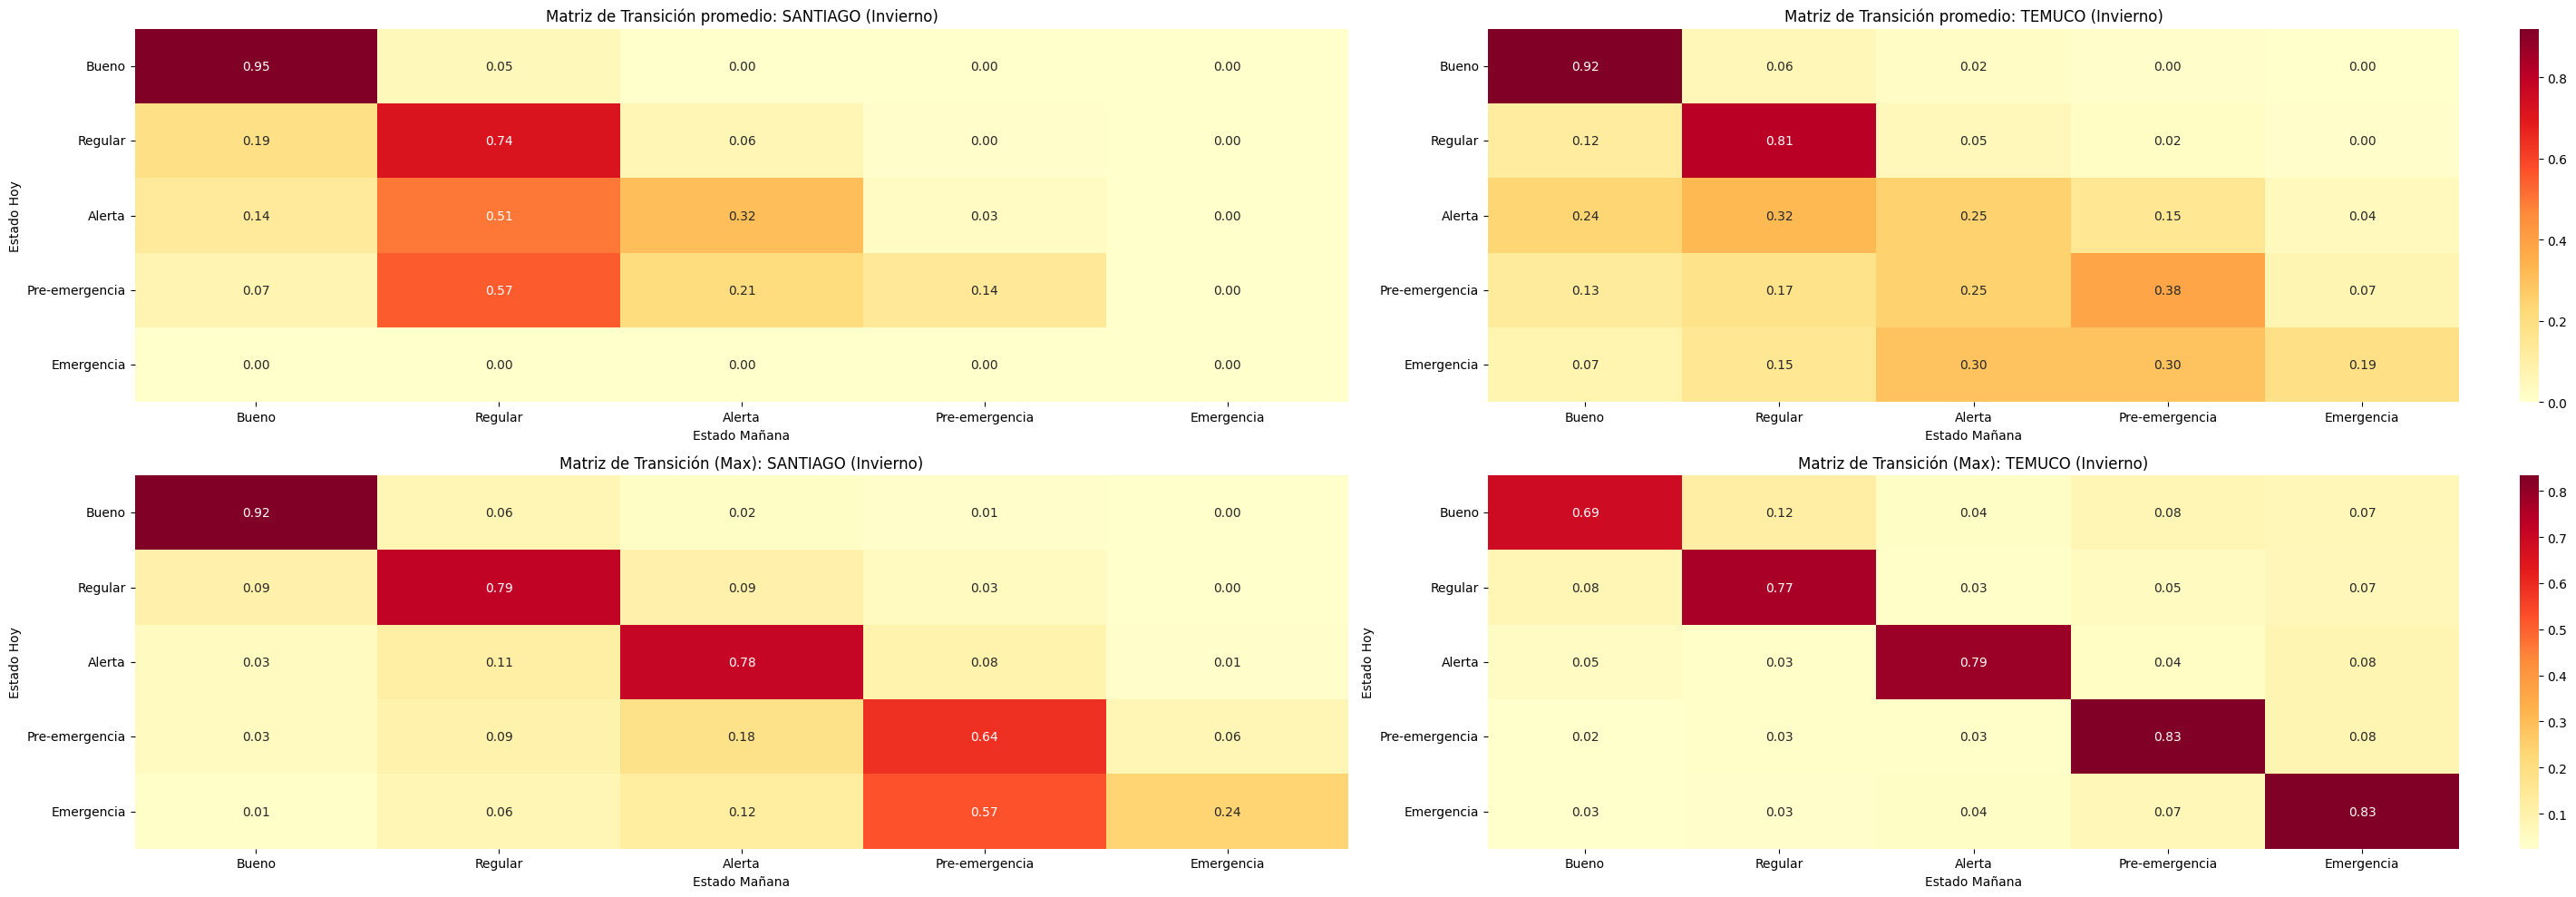

In [16]:
def calcular_matriz_transicion(df_horario, nombre_ciudad, metodo):
    # 1. Agregación Diaria: Pasamos de horas a DÍAS
    
    if metodo == "promedio":
        # Usamos el promedio diario de MP2.5
        df_diario = df_horario.set_index('fecha').resample('D')['mp25'].mean().to_frame()
    
    else:
        df_diario = df_horario.set_index('fecha').resample('D')['mp25'].max().to_frame()
    
    # Limpiamos días que pudieron quedar vacíos por el resample
    df_diario.ffill(inplace=True)
    df_diario.bfill(inplace=True)
    
    # 2. Clasificar el Día completo
    def clasificar_aire(valor):
        if valor <= 49: return "Bueno"
        elif valor <= 79: return "Regular"
        elif valor <= 109: return "Alerta"
        elif valor <= 169: return "Pre-emergencia"
        else: return "Emergencia"
        
    df_diario['estado_hoy'] = df_diario['mp25'].apply(clasificar_aire)
    
    # 3. Crear columna del "Estado Mañana" (Shift -1)
    df_diario['estado_manana'] = df_diario['estado_hoy'].shift(-1)
    
    # Eliminamos el último día porque no tiene "mañana"
    df_diario.dropna(inplace=True)
    
    # 4. Matriz de Conteo (Frecuencias)
    # Definimos el orden explícito para que la matriz quede ordenada de Bueno a Emergencia
    orden_estados = ["Bueno", "Regular", "Alerta", "Pre-emergencia", "Emergencia"]
    
    matriz_conteo = pd.crosstab(
        df_diario['estado_hoy'], 
        df_diario['estado_manana'], 
        normalize='index' # Esto convierte conteos a probabilidades (suma fila = 1)
    )
    
    # Reordenamos filas y columnas para que se vea ordenado en el gráfico
    # .reindex asegura que aparezcan todos los estados incluso si alguno no ocurrió
    matriz_prob = matriz_conteo.reindex(index=orden_estados, columns=orden_estados, fill_value=0)
    
    return matriz_prob

# Calculamos las matrices
matriz_stgo_prom = calcular_matriz_transicion(df_santiago, "Santiago", "promedio")
matriz_temuco_prom = calcular_matriz_transicion(df_temuco, "Temuco", "promedio")
matriz_stgo_max = calcular_matriz_transicion(df_santiago, "Santiago", "max")
matriz_temuco_max = calcular_matriz_transicion(df_temuco, "Temuco", "max")

# Visualización con Heatmaps
fig, axes = plt.subplots(2, 2, figsize=(30, 10))

# Heatmap Santiago (Promedio)
sns.heatmap(matriz_stgo_prom, annot=True, fmt=".2f", cmap="YlOrRd", cbar=False, ax=axes[0, 0])
axes[0, 0].set_title("Matriz de Transición promedio: SANTIAGO (Invierno)")
axes[0, 0].set_ylabel("Estado Hoy")
axes[0, 0].set_xlabel("Estado Mañana")

# Heatmap Temuco (Promedio)
sns.heatmap(matriz_temuco_prom, annot=True, fmt=".2f", cmap="YlOrRd", cbar=True, ax=axes[0, 1])
axes[0, 1].set_title("Matriz de Transición promedio: TEMUCO (Invierno)")
axes[0, 1].set_ylabel("")
axes[0, 1].set_xlabel("Estado Mañana")

# Heatmap Santiago (Max)
sns.heatmap(matriz_stgo_max, annot=True, fmt=".2f", cmap="YlOrRd", cbar=False, ax=axes[1, 0])
axes[1, 0].set_title("Matriz de Transición (Max): SANTIAGO (Invierno)")
axes[1, 0].set_ylabel("Estado Hoy")
axes[1, 0].set_xlabel("Estado Mañana")

# Heatmap Temuco (Max)
sns.heatmap(matriz_temuco_max, annot=True, fmt=".2f", cmap="YlOrRd", cbar=True, ax=axes[1, 1])
axes[1, 1].set_title("Matriz de Transición (Max): TEMUCO (Invierno)")
axes[1, 1].set_ylabel("Estado Hoy")
axes[1, 1].set_xlabel("Estado Mañana")

plt.tight_layout()
plt.show()

In [24]:
def simular_riesgo(matriz_transicion, estado_inicial, dias_proyeccion, num_simulaciones=100000):
    """
    Simula N días futuros dado un estado inicial y cuenta cuántas veces 
    llegamos a situaciones críticas.
    """
    estados = matriz_transicion.columns.tolist()
    conteo_emergencias = 0
    conteo_preemergencias = 0
    
    # Validar que el estado inicial exista en la matriz
    if estado_inicial not in estados:
        print(f"Error: El estado '{estado_inicial}' no existe en la matriz.")
        return

    for i in range(num_simulaciones):
        estado_actual = estado_inicial
        llego_a_emergencia = False
        llego_a_pre = False
        
        for dia in range(dias_proyeccion):
            # Obtenemos las probabilidades de transición para el estado actual
            probs = matriz_transicion.loc[estado_actual].values
            
            # Verificación de seguridad: si las probs suman 0 o NaN (caso raro), quedarse en el mismo estado
            if np.isnan(probs).any() or probs.sum() == 0:
                break

            # Elegimos el siguiente estado basado en las probabilidades
            estado_actual = np.random.choice(estados, p=probs)
            
            # Chequeamos si tocamos estados críticos
            if estado_actual == "Emergencia":
                llego_a_emergencia = True
            if estado_actual == "Pre-emergencia":
                llego_a_pre = True
        
        # Contabilizamos si en ALGÚN momento de los 7 días ocurrió el evento
        if llego_a_emergencia:
            conteo_emergencias += 1
        if llego_a_pre:
            conteo_preemergencias += 1
            
    prob_emergencia = conteo_emergencias / num_simulaciones
    prob_pre = conteo_preemergencias / num_simulaciones
    
    return prob_emergencia, prob_pre

# --- EJECUTAR LA COMPARACIÓN ---

# Definir escenario
estado_inicio = "Alerta"
dias = 7

print(f"--- SIMULACIÓN A {dias} DÍAS (Iniciando en {estado_inicio}) ---")

# 1. Simular con Matriz PROMEDIO (La "oficial")
p_emerg_mean, p_pre_mean = simular_riesgo(matriz_stgo_prom, estado_inicio, dias) 
print(f"[Criterio Promedio] Prob. de Emergencia: {p_emerg_mean:.1%}")

# 2. Simular con Matriz MÁXIMO (La "realista")
p_emerg_max, p_pre_max = simular_riesgo(matriz_stgo_max, estado_inicio, dias)
print(f"[Criterio Máximo]   Prob. de Emergencia: {p_emerg_max:.1%}")

--- SIMULACIÓN A 7 DÍAS (Iniciando en Alerta) ---
[Criterio Promedio] Prob. de Emergencia: 0.0%
[Criterio Promedio] Prob. de Emergencia: 0.0%
[Criterio Máximo]   Prob. de Emergencia: 6.9%
[Criterio Máximo]   Prob. de Emergencia: 6.9%
